This notebook includes Aaron's attempts at EDA, feature selection/reduction, and initial attempts at trying a couple of different predictive regression models (including hyperparameter tuning)

The outline:

1. Import the data. These include the accelerometer predictors. We should consider doing a separate analysis without these variables, since relatively few participants have these data
2. Remove a couple of variables we won't be using, including:
    * id
    * ID
    * BIA-BIA_BMI (since we already have a BMI variable as part of the physical group)
    * PCIAT-PCIAT_01 through 20
    * FitnessGram Zone variables that were used to compute the Zone Total (i.e., CU, PU, SRL, SRR, TL) *Note - not entirely sure if we should be doing this*
3. Examining correlations between each predictor (individually) and 
    * PCIAT-PCIAT_Total
    * log(PCIAT-PCIAT_Total)
    * (PCIAT-PCIAT_Total)^2
4. Examining NaN counts for all variables and, potentially, removing variables that:
    * Have very large NaN counts AND
    * Don't have face value as predictors AND
    * Have low correlations with the outcome variable
5. Examining correlations between all predictors and, potentially, removing variables that have extremely high (>0.9) correlation
6. Exploring interactions between Seasons and associated predictors:
    1. For each predictor that is associated with a Season variable (e.g., within the Physical variables), make a scatterplot of the predictor vs. outcome and display regression lines by Season
    2. If there aren't any clear interactions, removing the Season variable from the list of predictors
    3. If there do appear to be interactions, creating dummy variables from the Season variable
7. Create a linear regression model using a greedy algorithm from the "bottom up"
    1. Make a list of all numerical predictors and also a new empty data frame with 100(?) rows and the predictors as variables
    2. Randomly select a predictor from the list and create a linear model
    3. Randomly select a second predictor from the list and add it to the model
    4. Perform an F test to see if the new model is significantly better than the old
    5. Repeat until the F test is no longer significant
    6. Record the predictors that are in the model in the newly-created data frame
    7. Repeat the above steps 100 (??) times
    8. Compute the mean for each predictor in the data frame. This should give some sense of the "importance" of each predictor
8. Repeat the previous method but using a "top down" algorithm, starting with a full model and removing predictors one-by-one
9. *Maybe* Trying to use PCA and either linear or KNN regression to see if it appears to improve prediction
    * PCA on the entire set of predictors
    * On each set of grouped predictors
10. Using RandomForest Regression on the entire set of predictors and examining the importance matrix to try to find a potential list of predictors
11. *Maybe* using XGBoost to do stuff. (Need to learn what this is)
12. Removing highly-correlated predictors and using LASSO and using LASSO regression (with hyperparameter tuning) to identify important predictors
13. Comparing the apparent predictive power of all the previous methods. If none stand out, then stick with linear regression(?)
14. Start to engage more formally with the modeling process, using Kfold splits

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Load the original data set
train_cleaned = pd.read_csv('train_cleaned.csv')

In [18]:
# Remove some variables we won't need

# Remove the variables 'id', 'BIA-BIA_BMI'
train_cleaned = train_cleaned.drop(['id', 'BIA-BIA_BMI'], axis=1)

# Remove the PCIAT component variables
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.startswith('PCIAT-PCIAT_0')]
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.startswith('PCIAT-PCIAT_1')]
train_cleaned = train_cleaned.drop(['PCIAT-PCIAT_20'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRR_Zone, and FGC-FGC_TL_Zone
train_cleaned = train_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone'], axis=1)

In [19]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['sii', 'PCIAT-PCIAT_Total'])

In [20]:
# Compute absolute values of correlations between each predictor in numeric_features and PCIAT-PCIAT_Total
correlations = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['PCIAT-PCIAT_Total'])))

# Order correlations from largest to smallest
correlations = correlations.sort_values(ascending=False)

correlations

Physical-Height                           0.418307
Basic_Demos-Age                           0.413493
BIA-BIA_LDM                               0.394265
BIA-BIA_FFM                               0.393365
BIA-BIA_BMR                               0.393365
BIA-BIA_LST                               0.390155
BIA-BIA_TBW                               0.383273
PreInt_EduHx-computerinternet_hoursday    0.379375
BIA-BIA_ICW                               0.376192
BIA-BIA_SMM                               0.376079
BIA-BIA_ECW                               0.371151
BIA-BIA_DEE                               0.361941
Physical-Weight                           0.350290
Physical-Waist_Circumference              0.320012
FGC-FGC_CU                                0.314362
BIA-BIA_Fat                               0.283295
BIA-BIA_FFMI                              0.266804
ENMO_Avg_Active_Days_MVPA110              0.264020
Physical-BMI                              0.246296
SDS-SDS_Total_Raw              

Height, age, and weight are among the strong(er) predictors of the PCIAT_Total outcome.

There appear to be a constellation of BIA variables that are predictors, but prior exploration suggests that these might be strongly correlated with height and weight (and maybe age), so they might be candidates for elimination.

It's possible that there are some non-linear associations. So we'll compute log and ^2 of the outcome variable and re-compute correlations

In [21]:
# Create a new variable that is log(PCIAT-PCIAT_Total)
train_cleaned['log_PCIAT-PCIAT_Total'] = np.log(train_cleaned['PCIAT-PCIAT_Total'])

# Replace -inf values in log_PCIAT-PCIAT_Total with -1
train_cleaned['log_PCIAT-PCIAT_Total'] = train_cleaned['log_PCIAT-PCIAT_Total'].replace(-np.inf, -1)

# Compute absolute values of correlations between each predictor in numeric_features and log_PCIAT-PCIAT_Total
correlations_log = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['log_PCIAT-PCIAT_Total'])))
correlations_log = correlations_log.sort_values(ascending=False)

correlations_log.head(10)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Physical-Height                           0.371769
Basic_Demos-Age                           0.361570
BIA-BIA_LDM                               0.333092
BIA-BIA_FFM                               0.328185
BIA-BIA_BMR                               0.328184
BIA-BIA_LST                               0.325526
BIA-BIA_TBW                               0.318261
PreInt_EduHx-computerinternet_hoursday    0.313368
BIA-BIA_ECW                               0.313339
BIA-BIA_ICW                               0.307139
dtype: float64

The ordering of these variables is roughly unchanged, but the correlation values have decreased. So it doesn't seem to be the case that any of the predictors have a strong(er) correlation with log(PCIAT_Total)

In [22]:
# Create a new variable that is (PCIAT-PCIAT_Total)^2
train_cleaned['squared_PCIAT-PCIAT_Total'] = train_cleaned['PCIAT-PCIAT_Total']**2

# Compute absolute values of correlations between each predictor in numeric_features and squared_PCIAT-PCIAT_Total
correlations_squared = train_cleaned[numeric_features].apply(lambda x: np.abs(x.corr(train_cleaned['squared_PCIAT-PCIAT_Total'])))
correlations_squared = correlations_squared.sort_values(ascending=False)
correlations_squared.head(10)

Basic_Demos-Age                           0.380519
Physical-Height                           0.377620
BIA-BIA_BMR                               0.371778
BIA-BIA_FFM                               0.371778
BIA-BIA_LDM                               0.371706
BIA-BIA_LST                               0.367250
BIA-BIA_SMM                               0.362861
BIA-BIA_TBW                               0.362573
BIA-BIA_ICW                               0.358139
PreInt_EduHx-computerinternet_hoursday    0.349693
dtype: float64

Same results for the square relationship as with log. So we'll stick with examining linear relationships. We can remove the newly-created log/square predictors

In [23]:
# Remove the log_PCIAT-PCIAT_Total and squared_PCIAT-PCIAT_Total variables
train_cleaned = train_cleaned.drop(['log_PCIAT-PCIAT_Total', 'squared_PCIAT-PCIAT_Total'], axis=1)

In [24]:
# List the number of NaN values for each variable
train_cleaned.isnull().sum().sort_values(ascending=False)

Fitness_Endurance_Total_Time_Sec          2562
Fitness_Endurance-Max_Stage               2561
Physical-Waist_Circumference              2473
Positive_Anglez_Active_Days               2372
ENMO_Avg_Active_Days_MVPA110              2372
ENMO_Avg_Active_Days_MVPA192              2372
FGC-FGC_GSD_Zone                          2329
FGC-FGC_GSND_Zone                         2328
FGC-FGC_GSD                               2324
FGC-FGC_GSND                              2322
Fitness_Endurance-Season                  2108
PAQ_MVPA                                  1795
BIA-BIA_FMI                               1605
BIA-BIA_Fat                               1605
BIA-BIA_BMC                               1604
BIA-BIA_FFMI                              1588
BIA-BIA_SMM                               1583
BIA-BIA_DEE                               1583
BIA-BIA_ICW                               1582
BIA-BIA_LDM                               1582
BIA-BIA_LST                               1582
BIA-BIA_TBW  

There are some variables with a *lot* of missing information. But maybe the distribution (among participants) of number of NaN values is bimodal - perhaps there are a lot of people who are missing data for most of the variables.

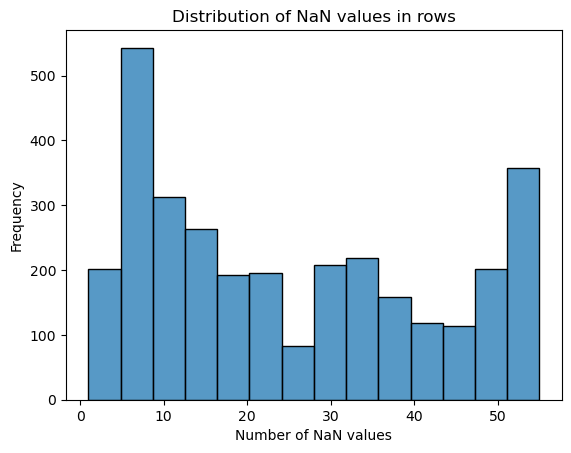

In [25]:
# Count the number of NaN values for each row and create a histogram of the distribution of these values
train_cleaned['NaN_count'] = train_cleaned.isnull().sum(axis=1)
sns.histplot(train_cleaned['NaN_count'])
plt.xlabel('Number of NaN values')
plt.ylabel('Frequency')
plt.title('Distribution of NaN values in rows')
plt.show()

The distribution looks multimodal. There are ~450 people who are missing data for nearly all of the variables, a group who are missing data for a few, and then a group who are missing data for about half.

These numbers are probably affected by the grouping into Physical, FitnessGram, and BIA—it seems likely that individuals would either have data for all of the predictors in a category or none of the predictors.

Doing regression requires values for all predictors. So we'll need to do one of the following: 
1. Focus on the ~300 participants who have data for (nearly) all of the variables, 
2. Focus only on the variables for which all participants have data
3. Some balance between these options -- eliminate a small number of high-NaN variables and then eliminate participants with NaN values in the remaining variables.

Big question: What should our target sample size be for running the regression?

In [26]:
# Make a data frame consisting of rows where NaN_count is at least 50
train_cleaned_high_nan = train_cleaned[train_cleaned['NaN_count'] >= 50]

train_cleaned_high_nan.head(20)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,sii,ENMO_Avg_Active_Days_MVPA192,ENMO_Avg_Active_Days_MVPA110,Positive_Anglez_Active_Days,FitnessGram_Zone_Total,PAQ_Total,PAQ_Season,PAQ_MVPA,Fitness_Endurance_Total_Time_Sec,NaN_count
1,Summer,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.24,Fall,0.0,NaN,50
2,Summer,9,1,NaN,NaN,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
4,Summer,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
9,Winter,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
15,Spring,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
31,Fall,5,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51
33,Spring,8,0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54
35,Fall,10,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54
39,Spring,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
46,Winter,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
